# Feature selection

In [1]:
%load_ext autoreload
%autoreload 2

!python --version

Python 3.7.6


In [2]:
import sys
sys.path.append('..')

## Classification

In [3]:
from sklearn.ensemble import RandomForestClassifier

from src.dataset import DatasetForClassification

from src.evaluation import custom_classification_report

from sklearn.metrics import f1_score

In [12]:
def get_removed_columns(sel):
    removed_columns = []
    
    for include, column in zip(sel.get_support(), X_train.columns):
        if not include:
            removed_columns.append(column)
    return removed_columns

In [106]:
def evaluate(removed_columns, X_train, X_test, y_train, y_test, **kwargs):
    full_report = kwargs.get('full_report', True)
    
    if removed_columns is None:
        X_train_new = X_train.copy()
        X_test_new = X_test.copy()
    else:
        X_train_new = X_train.drop(columns=removed_columns)
        X_test_new = X_test.drop(columns=removed_columns)
    
    if full_report:
        print(f'Old train shape - {X_train.shape}')
        print(f'New train shape - {X_train_new.shape}')
        
    print(f'Removed features - {len(X_train.columns) - len(X_train_new.columns)}')
    
    if full_report and removed_columns is not None:
        print(removed_columns)
        print([x for x in X_train.columns if x not in removed_columns])
    
    clf = RandomForestClassifier(random_state=42)
    clf = clf.fit(X_train_new, y_train)

    y_pred = clf.predict(X_test_new)

    print('\nResults:')

    for average in ['micro', 'macro']:
        print(f'{average}: {f1_score(y_test, y_pred, average=average)}')

### Load the dataset

In [142]:
dataset = DatasetForClassification('../data/fifa_processed_for_cls.csv', ['Position (4)', 'Position (13)'])

### Classification of (Position 4)

In [7]:
X_train, X_test, y_train, y_test = dataset.get_data('Position (4)')

labels = dataset.get_labels('Position (4)')

#### Baseline model

In [74]:
evaluate(None, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 52)
Removed features - 0

Results:
micro: 0.8931129476584022
macro: 0.903961614778307


#### VarianceThreshold

Remove all low-variance features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

In [75]:
%%time

from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit(X_train)

removed_columns = get_removed_columns(sel)        

evaluate(removed_columns, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 46)
Removed features - 6
['Preferred Foot_nan', 'Work Rate Attack_Low', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_nan']

Results:
micro: 0.8922865013774105
macro: 0.902590815953739
CPU times: user 3.52 s, sys: 29.9 ms, total: 3.55 s
Wall time: 3.55 s


####  Univariate feature selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

https://scikit-learn.org/stable/modules/feature_selection.html

In [80]:
%%time

from sklearn.feature_selection import GenericUnivariateSelect, chi2

modes = ['percentile', 'k_best', 'fpr', 'fdr', 'fwe']
params = [80, 42, 0.01, 0.01, 0.01]

for mode, param in zip(modes, params):
    print('\n---\n')
    print(f'Mode: {mode}\n')

    sel = GenericUnivariateSelect(chi2, mode, param=param)
    sel.fit(X_train, y_train)

    removed_columns = get_removed_columns(sel)

    evaluate(removed_columns, X_train, X_test, y_train, y_test, full_report=False);
    
    print('\n---\n')


---

Mode: percentile

Removed features - 11

Results:
micro: 0.8931129476584022
macro: 0.9035107745460405

---


---

Mode: k_best

Removed features - 10

Results:
micro: 0.8961432506887053
macro: 0.9059228234182279

---


---

Mode: fpr

Removed features - 3


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:592: RuntimeWarning: invalid value encountered in less
  return self.pvalues_ < self.alpha



Results:
micro: 0.890633608815427
macro: 0.9015325292857672

---


---

Mode: fdr

Removed features - 3


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:661: RuntimeWarning: invalid value encountered in less_equal
  np.arange(1, n_features + 1)]
/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:664: RuntimeWarning: invalid value encountered in less_equal
  return self.pvalues_ <= selected.max()



Results:
micro: 0.890633608815427
macro: 0.9015325292857672

---


---

Mode: fwe

Removed features - 3


/opt/conda/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))



Results:
micro: 0.890633608815427
macro: 0.9015325292857672

---

CPU times: user 18.1 s, sys: 586 ms, total: 18.6 s
Wall time: 17.4 s


#### SelectFromModel

In [109]:
from sklearn.feature_selection import SelectFromModel

thresholds = ['0.5*mean', '0.75*mean', 'mean', '1.25*mean', '1.75*mean', '2*mean']            

for threshold in thresholds:
    print('\n---')
    print(f'Threshold: {threshold}')

    sel = SelectFromModel(estimator=RandomForestClassifier(random_state=42), threshold=threshold).fit(X_train, y_train)

    removed_columns = get_removed_columns(sel)

    evaluate(removed_columns, X_train, X_test, y_train, y_test);
    
    print('\n---\n')


---
Threshold: 0.5*mean
Old train shape - (14517, 52)
New train shape - (14517, 32)
Removed features - 20
['Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'Agility', 'Reactions', 'Balance', 'Stamina', 'Composure', 'Age', 'Potential', 'Weak Foot', 'Height']
['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'ShotPower', 'Jumping', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Overall', 'Skill Moves', 'Weight']

Results:
micro: 0.890633608815427
macro: 0.9024651751688806

---


---
Thresh

#### Recursive feature elimination with cross-validation

Optimal number of features : 52


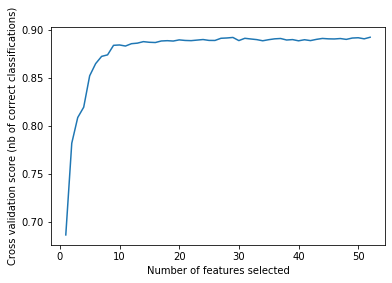

CPU times: user 3min 1s, sys: 1.68 s, total: 3min 2s
Wall time: 3min 3s


In [111]:
%%time

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

cls = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=cls, step=1, cv=StratifiedKFold(2), scoring='f1_macro')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [112]:
removed_columns = get_removed_columns(rfecv)

evaluate(removed_columns, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 52)
Removed features - 0
[]
['Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Age', 'Overall', 'Potential', 'Weak Foot', 'Skill Moves', 'Height', 'Weight']

Results:
micro: 0.8931129476584022
macro: 0.903961614778307


### Tree-based feature selection¶

In [117]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)

removed_columns = get_removed_columns(sel)

evaluate(removed_columns, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 7)
Removed features - 45
['Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'Crossing', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Positioning', 'Penalties', 'Composure', 'Marking', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Age', 'Overall', 'Potential', 'Weak Foot', 'Skill Moves', 'Height', 'Weight']
['Finishing', 'HeadingAccuracy', 'LongPassing', 'Interceptions', 'Vision', 'StandingTackle', 'SlidingTackle']

Results:
micro: 0.8548209366391185
macro: 0.8750896890093544


### Classification of (Position 13)

In [148]:
X_train, X_test, y_train, y_test = dataset.get_data('Position (13)')

labels = dataset.get_labels('Position (13)')

#### Baseline model

In [149]:
evaluate(None, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 52)
Removed features - 0

Results:
micro: 0.6873278236914601
macro: 0.5041835824887555


#### Recursive feature elimination with cross-validation

Optimal number of features : 46


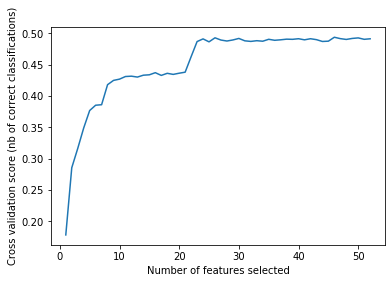

CPU times: user 4min 3s, sys: 1.06 s, total: 4min 4s
Wall time: 4min 5s


In [150]:
%%time

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

cls = RandomForestClassifier(random_state=42)

rfecv = RFECV(estimator=cls, step=1, cv=StratifiedKFold(2), scoring='f1_macro')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [151]:
removed_columns = get_removed_columns(rfecv)

evaluate(removed_columns, X_train, X_test, y_train, y_test);

Old train shape - (14517, 52)
New train shape - (14517, 46)
Removed features - 6
['Preferred Foot_nan', 'Work Rate Attack_Low', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_nan']
['Preferred Foot_Left', 'Preferred Foot_Right', 'Work Rate Attack_High', 'Work Rate Attack_Medium', 'Work Rate Defense_Medium', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Age', 'Overall', 'Potential', 'Weak Foot', 'Skill Moves', 'Height', 'Weight']

Results:
micro: 0.6881542699724518
macro: 0.5044827491873773


### Conclusion

We tried several methods of reducing the model features.

However, the model performed best when the all features was used (f1 macro 0.903).

Also, when some features were removed ~10 to ~20 the f1 macro raged from 0.890 to 0.905.

When we removed 42 features we achieved f1 macro of 0.89, this means we need only a few features (~10) to make the predictions.

## Regression

In [5]:
from sklearn.linear_model import LinearRegression

In [6]:
from src.dataset import DatasetForRegression

from src.evaluation import custom_regression_report

In [15]:
def evaluate_regression(removed_columns, X_train, X_test, y_train, y_test, **kwargs):
    full_report = kwargs.get('full_report', True)
    
    if removed_columns is None:
        X_train_new = X_train.copy()
        X_test_new = X_test.copy()
    else:
        X_train_new = X_train.drop(columns=removed_columns)
        X_test_new = X_test.drop(columns=removed_columns)
    
    if full_report:
        print(f'Old train shape - {X_train.shape}')
        print(f'New train shape - {X_train_new.shape}')
        
    print(f'Removed features - {len(X_train.columns) - len(X_train_new.columns)}')
    
    if full_report and removed_columns is not None:
        print(removed_columns)
        print([x for x in X_train.columns if x not in removed_columns])
    
    clf = LinearRegression()
    clf = clf.fit(X_train_new, y_train)

    custom_regression_report(clf, X_test_new, y_test, show_plot=kwargs.get('show_plot'))

### Load the dataset

In [8]:
dataset = DatasetForRegression('../data/fifa_processed_for_reg.csv', ['Value'])

In [9]:
X_train, X_test, y_train, y_test = dataset.get_data('Value')

### Regression "Value"

We will used the methods which looked to performed best previously.

#### Baseline model

Old train shape - (14325, 73)
New train shape - (14325, 73)
Removed features - 0
MSE: 12675958308862.986
RMSE: 3560331.207747811
Explained variance - uniform_average (higher is better): 0.6285853046833247
Explained variance - variance_weighted (higher is better): 0.6285853046833247




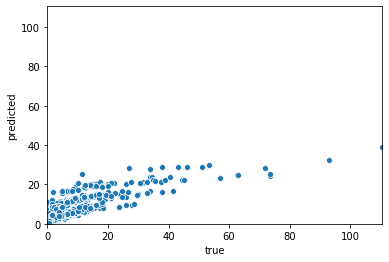

In [10]:
evaluate_regression(None, X_train, X_test, y_train, y_test, show_plot=False);

#### Recursive feature elimination with cross-validation

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


Optimal number of features : 71


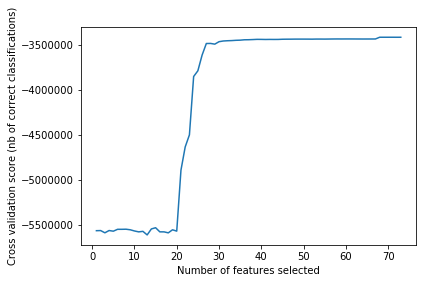

CPU times: user 9.17 s, sys: 7.54 s, total: 16.7 s
Wall time: 4.38 s


In [17]:
%%time

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

cls = LinearRegression()

rfecv = RFECV(estimator=cls, step=1, cv=StratifiedKFold(2), scoring='neg_root_mean_squared_error')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [18]:
removed_columns = get_removed_columns(rfecv)

evaluate_regression(removed_columns, X_train, X_test, y_train, y_test);

Old train shape - (14325, 73)
New train shape - (14325, 71)
Removed features - 2
['Position (13)_nan', 'Work Rate Attack_nan']
['Position (4)_attack', 'Position (4)_defense', 'Position (4)_goalkeeper', 'Position (4)_middle', 'Position (4)_nan', 'Position (13)_attacking midfielder', 'Position (13)_central attack', 'Position (13)_central defense', 'Position (13)_deffensive midfielder', 'Position (13)_goalkeeper', 'Position (13)_left attack', 'Position (13)_left defense', 'Position (13)_left midfielder', 'Position (13)_middle', 'Position (13)_midfielder', 'Position (13)_right attack', 'Position (13)_right defense', 'Position (13)_right midfielder', 'Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'Contract Length', 'International Reputation', 'Crossing', 'Finishing', 'HeadingAccuracy', 'Short

#### SelectFromModel

In [19]:
from sklearn.feature_selection import SelectFromModel

thresholds = ['0.5*mean', '0.75*mean', 'mean', '1.25*mean', '1.75*mean', '2*mean']            

for threshold in thresholds:
    print('\n---')
    print(f'Threshold: {threshold}')

    sel = SelectFromModel(estimator=RandomForestClassifier(random_state=42), threshold=threshold).fit(X_train, y_train)

    removed_columns = get_removed_columns(sel)

    evaluate_regression(removed_columns, X_train, X_test, y_train, y_test);
    
    print('\n---\n')


---
Threshold: 0.5*mean
Old train shape - (14325, 73)
New train shape - (14325, 41)
Removed features - 32
['Position (4)_attack', 'Position (4)_defense', 'Position (4)_goalkeeper', 'Position (4)_middle', 'Position (4)_nan', 'Position (13)_attacking midfielder', 'Position (13)_central attack', 'Position (13)_central defense', 'Position (13)_deffensive midfielder', 'Position (13)_goalkeeper', 'Position (13)_left attack', 'Position (13)_left defense', 'Position (13)_left midfielder', 'Position (13)_middle', 'Position (13)_midfielder', 'Position (13)_right attack', 'Position (13)_right defense', 'Position (13)_right midfielder', 'Position (13)_nan', 'Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'International Reputation', 'Skill Moves']
['Contract Length', 'Crossing

Old train shape - (14325, 73)
New train shape - (14325, 3)
Removed features - 70
['Position (4)_attack', 'Position (4)_defense', 'Position (4)_goalkeeper', 'Position (4)_middle', 'Position (4)_nan', 'Position (13)_attacking midfielder', 'Position (13)_central attack', 'Position (13)_central defense', 'Position (13)_deffensive midfielder', 'Position (13)_goalkeeper', 'Position (13)_left attack', 'Position (13)_left defense', 'Position (13)_left midfielder', 'Position (13)_middle', 'Position (13)_midfielder', 'Position (13)_right attack', 'Position (13)_right defense', 'Position (13)_right midfielder', 'Position (13)_nan', 'Preferred Foot_Left', 'Preferred Foot_Right', 'Preferred Foot_nan', 'Work Rate Attack_High', 'Work Rate Attack_Low', 'Work Rate Attack_Medium', 'Work Rate Attack_nan', 'Work Rate Defense_High', 'Work Rate Defense_Low', 'Work Rate Defense_Medium', 'Work Rate Defense_nan', 'Contract Length', 'International Reputation', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortP

### Conclusion

The pattern is roughly the same again, the more features we have, the better model we train.